# Coupon collector's problem (Sammelbilderproblem)

Lets try to simulate it first (with good old numpy.random.randint()):

In [1]:
%matplotlib inline

import numpy
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
images = 25
max_tries = 450
total_rounds = 1000000

In [3]:
def try_attempt(args=None):
    set_counter = numpy.zeros(images)
    attempt = 0
    num_filled = 0
    
    while not num_filled == images:
        attempt += 1 
        n = numpy.random.randint(low=0, high=images)
        if set_counter[n] == 0:
            set_counter[n] = 1
            num_filled += 1
    
    return attempt

In [4]:
# Embarrassingly parallel for loops with joblib
from joblib import Parallel, delayed

every_attempt = Parallel(n_jobs=-1)(delayed(try_attempt)() for i in range(0, total_rounds))

In [5]:
# python stdlib multiprocessing. Only works within IPython/Jupyter on Linux due to how it spawns processes
from multiprocessing import Pool

with Pool() as p:
    every_attempt = p.map(try_attempt, range(0, total_rounds))

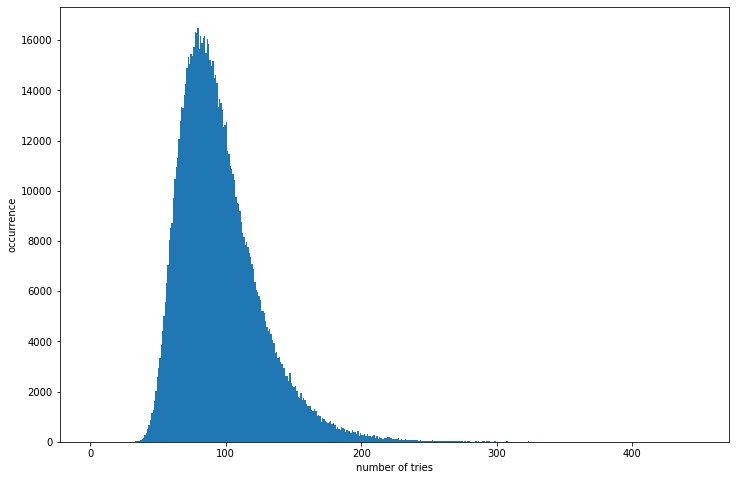

In [6]:
n, _, _ = plt.hist(every_attempt, bins=range(0, max_tries), label="attempts")
plt.xlabel('number of tries')
plt.ylabel('occurrence')
plt.show()

In [7]:
print("When collecting", images, "images in a set, simulating", total_rounds, "tries:")
print("The average number tries to get all is", numpy.mean(every_attempt), "images.")
print("the 95 percentile is", numpy.percentile(every_attempt, 95), "images,")
print("the minimum is", numpy.min(every_attempt), "images,")
print("the maximum is", numpy.max(every_attempt), "images.")

When collecting 25 images in a set, simulating 1000000 tries:
The average number tries to get all is 95.335332 images.
the 95 percentile is 152.0 images,
the minimum is 32 images,
the maximum is 384 images.


## Now with theory

How long does it take to collect n images: $X_i$ is the number of images to collect to go from $i-1$ to $i$, $p_i$ the corresponding propability:

$$p_i = \frac{n+1-1}{n}, i=1,2,3...,n $$

The $X_i$ are independent random variables, thus the sum $T_n$ is the number of images to collect to get the whole set, its expected value $E(T_n)$ is:

$$E(T_n) = \frac{n}{n} + \frac{n}{n-1} + \frac{n}{n-2} + ... + n = n(1 + \frac{1}{2} + \frac{1}{3} + ...  + \frac{1}{n})$$ 

In [8]:
sum = 0
n = images
for i in range(1,n+1):
    sum += 1/i
sum *= n

print("The theoretical mean to collect a set of", n, "images is", sum, "images.")

The theoretical mean to collect a set of 25 images is 95.39895444383767 images.


Then we calculate the theoretical distribution, source is
http://groolfs.de/Verschiedenespdf/vollstaendigeSerie.pdf

We define the propability $P(T_n = k)$ as follows: Having exact $k$ tries to have a complete series with $n$ images.

Applying the sieve principle to the above results in:

$$P(T_n = k) = \sum_{r=1}^{n-1} (-1)^{r-1} \cdot {n\choose r} \cdot (1-\frac{r}{n})^{k-1} \cdot \frac{r}{n}$$

In [9]:
import math
import scipy.special

n = images
hist = numpy.zeros(max_tries)

for k in range(2,max_tries):
    sum = 0
    for r in range(1,n):
        sum += math.pow(-1, r-1) * scipy.special.binom(n, r) * math.pow(1-r/n, k-1) * r / n
    
    hist[k] = sum

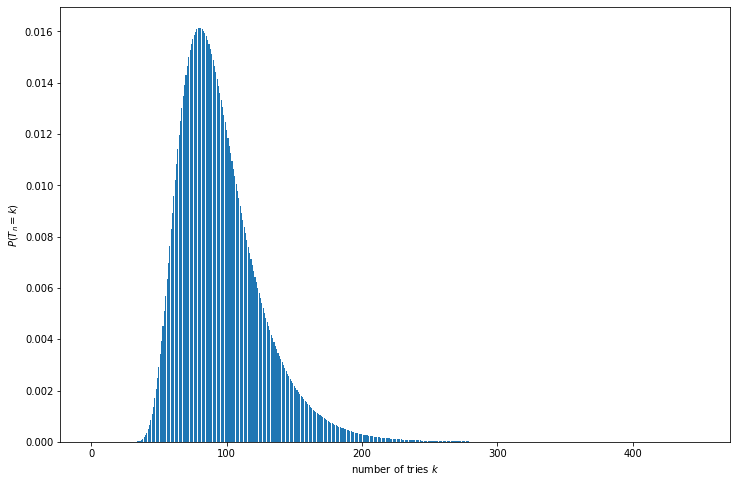

In [10]:
_ = plt.bar(range(0, max_tries), hist)
plt.xlabel('number of tries $k$')
plt.ylabel('$P(T_n=k)$')
plt.show()